In [ ]:
#from SimulatedLIBS import simulation
import time
import pandas as pd
import numpy as np
import h5py
import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from itertools import islice
import pickle
from sklearn.neural_network import MLPRegressor #Needs a lot of tuning
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gc
import itertools
from sklearn.metrics import mean_squared_error
import sklearn
from numpy import genfromtxt
from os import listdir
from os.path import isfile, join
import os
import copy
from scipy import interpolate
from sklearn.decomposition import PCA

In [ ]:
def load_dataset(datasets):
    start = time.time()
    count = 1
    wavelength_list = []
    intensity_list = []
    label_list = []
    get_wavelength = True
    for dataset_name in datasets:
        with h5py.File(dataset_name, "r") as f:
            if get_wavelength: wavelengths = np.array(np.split(f['wavelength'][:], f['wavelength'][:].shape[0]//4094))
            intensities = np.array(np.split(f['intensity'][:], f['intensity'][:].shape[0]//4094))
            labels = np.array(np.split(f['label'][:], f['label'][24:].shape[0]//24))/100 
            if get_wavelength: wavelength_list.append(wavelengths)
            intensity_list.append(intensities)
            label_list.append(labels)
            print(dataset_name, " Done")
        get_wavelength = False
    wavelengths = np.array(list(itertools.chain.from_iterable(wavelength_list)))
    intensities = np.array(list(itertools.chain.from_iterable(intensity_list)))
    labels = np.array(list(itertools.chain.from_iterable(label_list)))
    print(round(time.time()-start,2), "seconds")    
    return wavelengths, intensities, labels

def noiser(data,factor):
    cut_off = 1000000
    data = data.copy()
    data[data> int(cut_off*factor)] = cut_off*factor
    data = np.where(data <= int(cut_off*0.01*factor), int(cut_off*0.008*factor) + np.random.uniform(1,int((cut_off*0.001)*factor),data.shape), data) #add noise
    sklearn.preprocessing.minmax_scale(data, feature_range=(0, 1), axis=0, copy=False)
    return data

def load_csv_data(folder,shot):
    filenames = []
    dataframes = []
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(folder):
        listOfFiles += [ os.path.join(dirpath, file) for file in filenames if file.endswith('00'+shot+'.csv')]
    #for file in os.listdir(folder):
    #    if file.endswith('00'+shot+'.csv'):
    #        filenames.append(file)
    for name in listOfFiles:
        with open(name) as readfile:
            for cnt, line in enumerate(readfile):
                if "wavelength,intensity" in line:
                    row_num = cnt
        df = pd.read_csv(name, skiprows=row_num)
        dataframes.append(copy.deepcopy(df['intensity']))
        wavelength = copy.deepcopy(df['wavelength'])
    dataframes = np.array(dataframes)
    return dataframes, wavelength

def simple_labels(data,percentage):
    labels = np.full((data.shape[0]),percentage)
    return labels

def create_labels(elements, composition):
    labels = [0]*len(elements)
    labels_list = []
    for sample in composition:
        for element in composition[sample]['composition']:
            labels[elements.index(element)] = composition[sample]['composition'][element]/100
        for x in range(composition[sample]['spectra_n']):labels_list.append(labels)
        labels = [0]*len(elements)

    return np.array(labels_list)
### create_labels example
comp = {1: {'spectra_n': 100,
             'composition': {'Cu': 63.1, 'Zn': 35.8}},
          2: {'spectra_n': 100,
             'composition': {'Cu': 63.2, 'Zn': 35.7}},
          3: {'spectra_n': 100,
             'composition':  {'Cu': 63.3, 'Zn': 35.6}},
          4: {'spectra_n': 250,
             'composition': {'Cu': 63.2, 'Zn': 35.6}},
          5: {'spectra_n': 100,
             'composition': {'Cu': 63.6, 'Zn': 35.4}},
          'A': {'spectra_n': 250,
             'composition': {'Cu': 99.995}},
          'B': {'spectra_n': 250,
             'composition': {'Cu': 99.9}},
          'C': {'spectra_n': 250,
             'composition': {'Cu': 85, 'Zn': 14}},
}
###

elements = ['C', 'Mg', 'Al', 'Si', 'Ti', 'V', 'Fe', 'Co', 'Ni', 'Cu', 'Mn', 'Li', 'Zn', 'O', 'P', 'Pt', 'Au', 'Ag', 'Ir', 'W', 'Pd', 'Sn', 'Tc', 'Y']

def load_csv_and_labels(paths,labels):
    datasets = []
    labels_list = []
    for path, single_label in zip(paths,labels):
        x, wavelength = load_csv_data(path,'3')
        datasets.append(x)
        labels_list.append(simple_labels(x,single_label))
    return np.concatenate(datasets,axis=0), np.concatenate(labels_list, axis=None), wavelength


In [ ]:
csv_data4 = load_csv_data('datasets/090822_measurements/reference_samples/measurements13072022samples2/Al reference sample/','3') # last argument '3' is the number of shot the function will load from a folder
#labels4 = simple_labels(csv_data4,0.0)
csv_data5 = load_csv_data('datasets/090822_measurements/reference_samples/measurements 14072022samples2/Mg reference sample','3')
csv_data6 = load_csv_data('datasets/090822_measurements/reference_samples/measurements 14072022samples2/Si reference sample','3')
csv_data7 = load_csv_data('datasets/090822_measurements/reference_samples/measurements 14072022samples2/Zn reference sample','3')
csv_data8 = load_csv_data('datasets/090822_measurements/reference_samples/measurements19072022samples2/C reference sample','3')
csv_data9 = load_csv_data('datasets/090822_measurements/reference_samples/measurements19072022samples2/Ti reference sample','3')

csv_data = np.concatenate((csv_data4[0],csv_data5[0],csv_data6[0],csv_data7[0],csv_data8[0],csv_data9[0]),axis=0) 

In [ ]:
csv_data9[0].shape

(400, 4094)

In [ ]:
np.squeeze(csv_data).shape

(4,)

In [ ]:
pca = PCA(n_components=2, svd_solver='full') #here I have used 2 components for the 2d visualization, 2 components explained ~95% of variation, https://www.youtube.com/watch?v=FgakZw6K1QQ&ab_channel=StatQuestwithJoshStarmer there's an explanation about pca, good channel for data analysis things

In [ ]:
x = pca.fit_transform(csv_data5[0]) # fit the algorithm with desired data

In [ ]:
pca.get_feature_names_out()

array(['pca0', 'pca1'], dtype=object)

In [ ]:
pca.components_.shape

(2, 4094)

In [ ]:
csv_data4[0].shape

(300, 4094)

In [ ]:
x.shape

(400, 2)

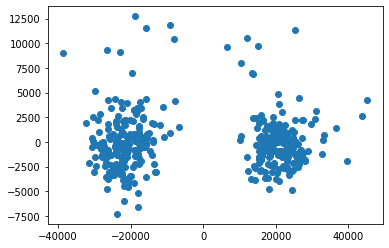

In [ ]:
import matplotlib.pyplot as plt
#Different kinds of plotting

#plt.scatter(x[:100,0],x[:100,1])
#plt.scatter(x[100:,0],x[100:,1])

plt.scatter(x[:,0],x[:,1])

#plt.scatter(x[:300,0],x[:300,1])
#plt.scatter(x[300:700,0],x[300:700,1])
#plt.scatter(x[700:1100,0],x[700:1100,1])
#plt.scatter(x[1100:1250,0],x[1100:1250,1])
#plt.scatter(x[1250:1450,0],x[1250:1450,1])
#plt.scatter(x[1450:1850,0],x[1450:1850,1])

plt.show()

In [ ]:
np.set_printoptions(suppress=True)#,formatter={'float_kind':'{:3.1f}'.format}, linewidth=130)


print(pca.explained_variance_)

[5.22228470e+09 1.11606403e+09 3.08575912e+08 4.69153077e+07 1.01805178e+07]


In [ ]:
csv_data4[0]

array([[708., 662., 710., ..., 681., 771., 622.],
       [706., 640., 725., ..., 685., 744., 645.],
       [684., 634., 710., ..., 661., 727., 650.],
       ...,
       [709., 662., 707., ..., 686., 724., 647.],
       [719., 678., 713., ..., 699., 739., 632.],
       [737., 632., 718., ..., 663., 711., 649.]])

In [ ]:
x.shape

(300, 5)

In [ ]:
pca.explained_variance_ratio_

array([0.7596881 , 0.16584322, 0.04290901, 0.02627901, 0.00168791])

In [ ]:
np.argmax(pca.components_[0])

4082

In [ ]:
pca.components_[0][4082]

0.0016629354954666266

In [ ]:
pca.components_[0]

array([0.00151987, 0.00138993, 0.00133137, ..., 0.00145837, 0.00145061, 0.00147014])

array([-21154.02815923, -31756.03869049,  53888.96358551,   1653.80592106,  -2757.33382441])